In [29]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path
import cv2
from tqdm import tqdm
import sys

In [30]:
# Add project root to path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))
sys.path.append(project_root)

# Import custom utilities
from src.utils.dataset_utils import download_dataset
from src.utils.directory_utils import display_directory_tree

In [31]:
# Download dataset
dataset_root = os.path.join(project_root, "data", "NUAA_dataset")
dataset_slug = "aleksandrpikul222/nuaaaa"

if not download_dataset(dataset_slug, dataset_root):
    raise Exception("Failed to download dataset")

Dataset already exists locally


In [32]:
# Display dataset structure
print("Dataset structure:")
display_directory_tree(dataset_root, max_depth=4)

Dataset structure:
NUAA_dataset/
    raw/
        client_test_raw.txt/
        client_train_raw.txt/
        ClientRaw/
            0001/
                0001_00_00_01_0.jpg/
                0001_00_00_01_101.jpg/
                0001_00_00_01_105.jpg/
                0001_00_00_01_109.jpg/
                0001_00_00_01_112.jpg/
                0001_00_00_01_116.jpg/
                0001_00_00_01_12.jpg/
                0001_00_00_01_123.jpg/
                0001_00_00_01_127.jpg/
                0001_00_00_01_130.jpg/
                ... (240 more)
            0002/
                0002_01_00_01_100.jpg/
                0002_01_00_01_109.jpg/
                0002_01_00_01_116.jpg/
                0002_01_00_01_120.jpg/
                0002_01_00_01_124.jpg/
                0002_01_00_01_128.jpg/
                0002_01_00_01_132.jpg/
                0002_01_00_01_136.jpg/
                0002_01_00_01_14.jpg/
                0002_01_00_01_143.jpg/
                ... (48 more)
       

In [33]:
# Setup paths
client_path = os.path.join(dataset_root, "raw", "ClientRaw")
imposter_path = os.path.join(dataset_root, "raw", "ImposterRaw")

In [34]:
# Basic stats
def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len([f for f in files if f.endswith((".jpg", ".png"))])
    return count


client_count = count_images(client_path)
imposter_count = count_images(imposter_path)

print("\nSummary Statistics:")
print(f"Number of real (client) images: {client_count}")
print(f"Number of spoof (imposter) images: {imposter_count}")


Summary Statistics:
Number of real (client) images: 5105
Number of spoof (imposter) images: 7509


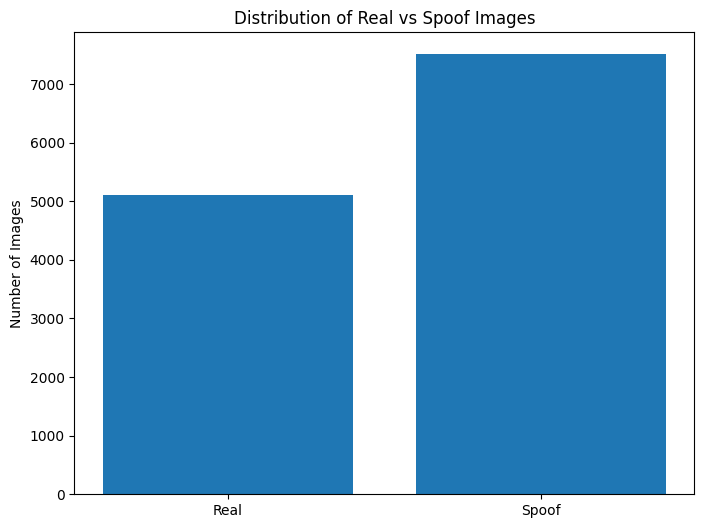

In [35]:
# Plot distribution
plt.figure(figsize=(8, 6))
plt.bar(["Real", "Spoof"], [client_count, imposter_count])
plt.title("Distribution of Real vs Spoof Images")
plt.ylabel("Number of Images")
plt.show()

In [36]:
# Image Analysis Functions
def analyze_image_stats(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return {
            "height": img.shape[0],
            "width": img.shape[1],
            "channels": img.shape[2],
            "mean_intensity": np.mean(img_gray),
            "std_intensity": np.std(img_gray),
            "filesize": os.path.getsize(image_path),
        }
    return None


# Process sample images
def analyze_sample_directory(directory):
    """Analyze all images in directory"""
    image_files = []
    for root, dirs, files in os.walk(directory):
        image_files.extend(
            [os.path.join(root, f) for f in files if f.endswith((".jpg", ".png"))]
        )

    if not image_files:
        return pd.DataFrame()

    stats = []
    for f in tqdm(image_files, desc=f"Analyzing {os.path.basename(directory)}"):
        image_stats = analyze_image_stats(f)
        if image_stats:
            stats.append(image_stats)

    return pd.DataFrame(stats)


# Analyze all images in both directories
print("\nAnalyzing image statistics...")
client_stats = analyze_sample_directory(client_path)
imposter_stats = analyze_sample_directory(imposter_path)


Analyzing image statistics...


Analyzing ImposterRaw: 100%|██████████| 7509/7509 [01:11<00:00, 104.60it/s]


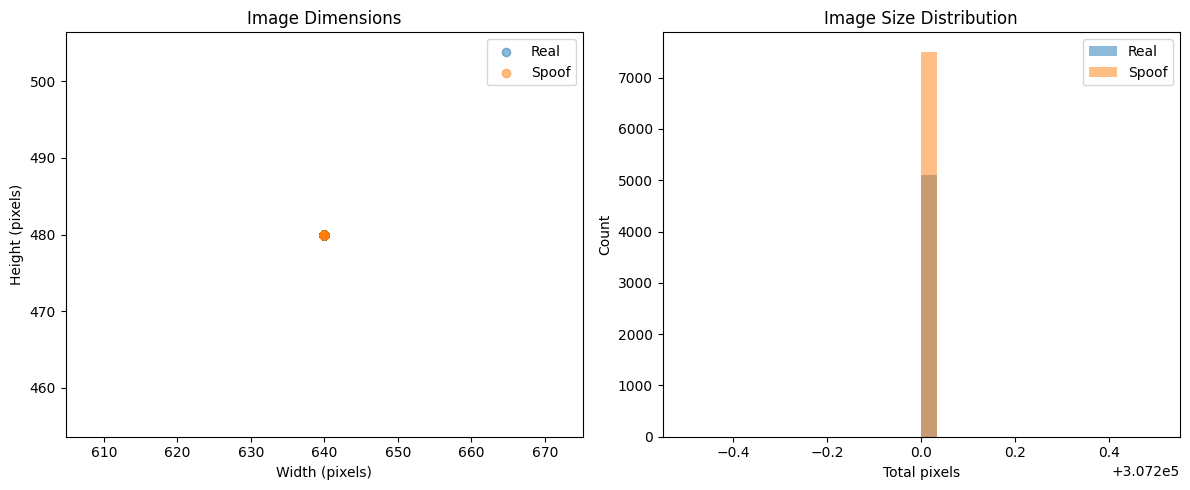

In [37]:
# Image dimensions analysis
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(client_stats["width"], client_stats["height"], alpha=0.5, label="Real")
plt.scatter(imposter_stats["width"], imposter_stats["height"], alpha=0.5, label="Spoof")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.title("Image Dimensions")
plt.legend()

plt.subplot(122)
plt.hist(
    client_stats["width"] * client_stats["height"], bins=30, alpha=0.5, label="Real"
)
plt.hist(
    imposter_stats["width"] * imposter_stats["height"],
    bins=30,
    alpha=0.5,
    label="Spoof",
)
plt.xlabel("Total pixels")
plt.ylabel("Count")
plt.title("Image Size Distribution")
plt.legend()
plt.tight_layout()
plt.show()

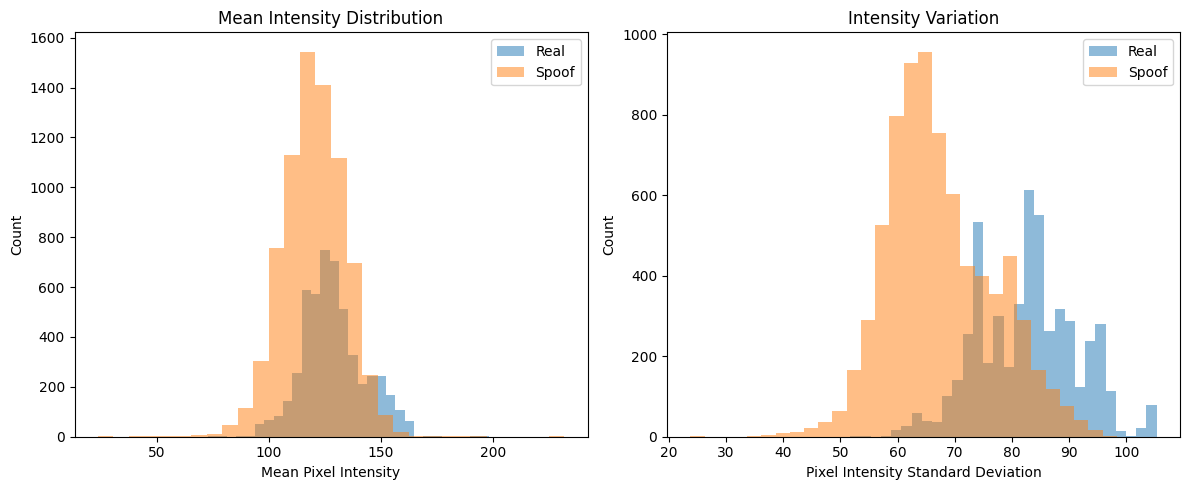

In [38]:
# Intensity distribution analysis
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.hist(client_stats.mean_intensity, bins=30, alpha=0.5, label="Real")
plt.hist(imposter_stats.mean_intensity, bins=30, alpha=0.5, label="Spoof")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Count")
plt.title("Mean Intensity Distribution")
plt.legend()

plt.subplot(122)
plt.hist(client_stats.std_intensity, bins=30, alpha=0.5, label="Real")
plt.hist(imposter_stats.std_intensity, bins=30, alpha=0.5, label="Spoof")
plt.xlabel("Pixel Intensity Standard Deviation")
plt.ylabel("Count")
plt.title("Intensity Variation")
plt.legend()
plt.tight_layout()
plt.show()

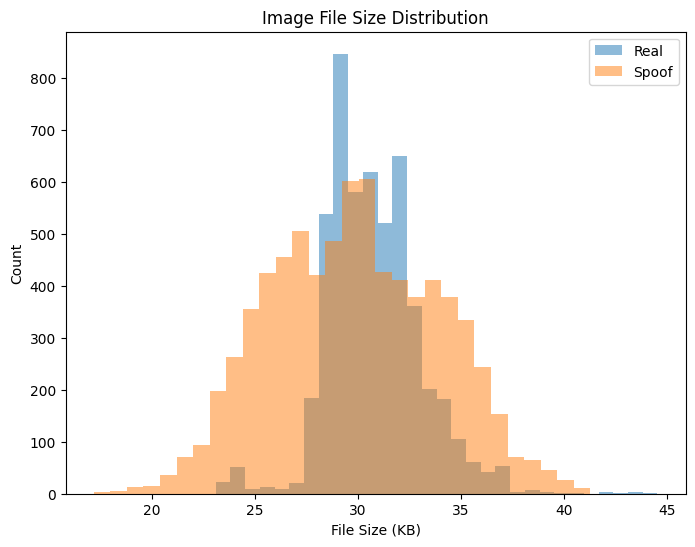

In [39]:
# File size analysis
plt.figure(figsize=(8, 6))
plt.hist(client_stats.filesize / 1024, bins=30, alpha=0.5, label="Real")
plt.hist(imposter_stats.filesize / 1024, bins=30, alpha=0.5, label="Spoof")
plt.xlabel("File Size (KB)")
plt.ylabel("Count")
plt.title("Image File Size Distribution")
plt.legend()
plt.show()


Analyzing face detection...


Detecting faces in ImposterRaw: 100%|██████████| 7509/7509 [04:33<00:00, 27.44it/s]


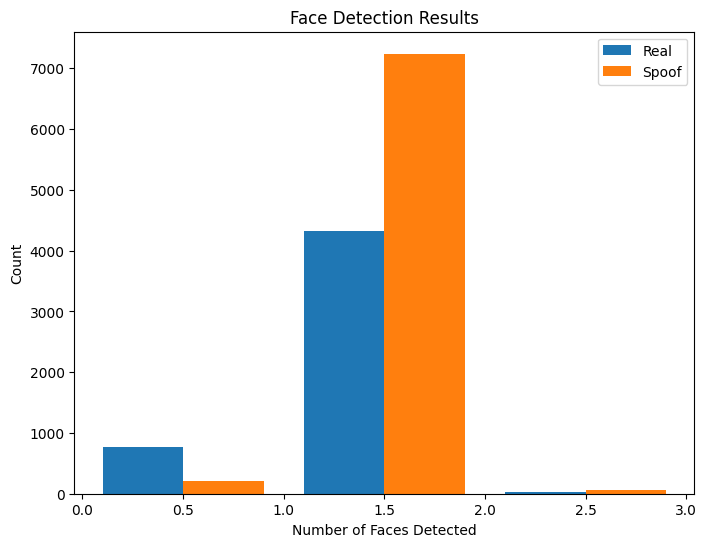

In [40]:
# Face detection analysis
def detect_faces(image_path):
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    img = cv2.imread(image_path)
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        return len(faces)
    return 0


# Analyze face detection in samples
def analyze_face_detection(directory):
    """Analyze face detection in all images"""
    files = []
    for root, dirs, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith((".jpg", ".png")):
                files.append(os.path.join(root, filename))

    if not files:
        return []

    face_counts = []
    for f in tqdm(files, desc=f"Detecting faces in {os.path.basename(directory)}"):
        face_count = detect_faces(f)
        face_counts.append(face_count)
    return face_counts


print("\nAnalyzing face detection...")
client_faces = analyze_face_detection(client_path)
imposter_faces = analyze_face_detection(imposter_path)

if len(client_faces) > 0 and len(imposter_faces) > 0:
    plt.figure(figsize=(8, 6))
    plt.hist(
        [client_faces, imposter_faces],
        label=["Real", "Spoof"],
        bins=range(max(max(client_faces), max(imposter_faces)) + 2),
    )
    plt.xlabel("Number of Faces Detected")
    plt.ylabel("Count")
    plt.title("Face Detection Results")
    plt.legend()
    plt.show()
else:
    print("No faces were detected in the sample images")


Analyzing image quality metrics...


Analyzing quality in ImposterRaw: 100%|██████████| 7509/7509 [00:45<00:00, 164.91it/s]
C:\Users\quang\AppData\Local\Temp\ipykernel_25564\3306740200.py:60: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(
C:\Users\quang\AppData\Local\Temp\ipykernel_25564\3306740200.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(["Real", "Spoof"])
C:\Users\quang\AppData\Local\Temp\ipykernel_25564\3306740200.py:60: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(
C:\Users\quang\AppData\Local\Temp\ipykernel_25564\3306740200.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(["Real", "Spoof"])
C:\Users\quang\AppData\Local\Temp\ipykernel_25564\3306740200.py:60: Use

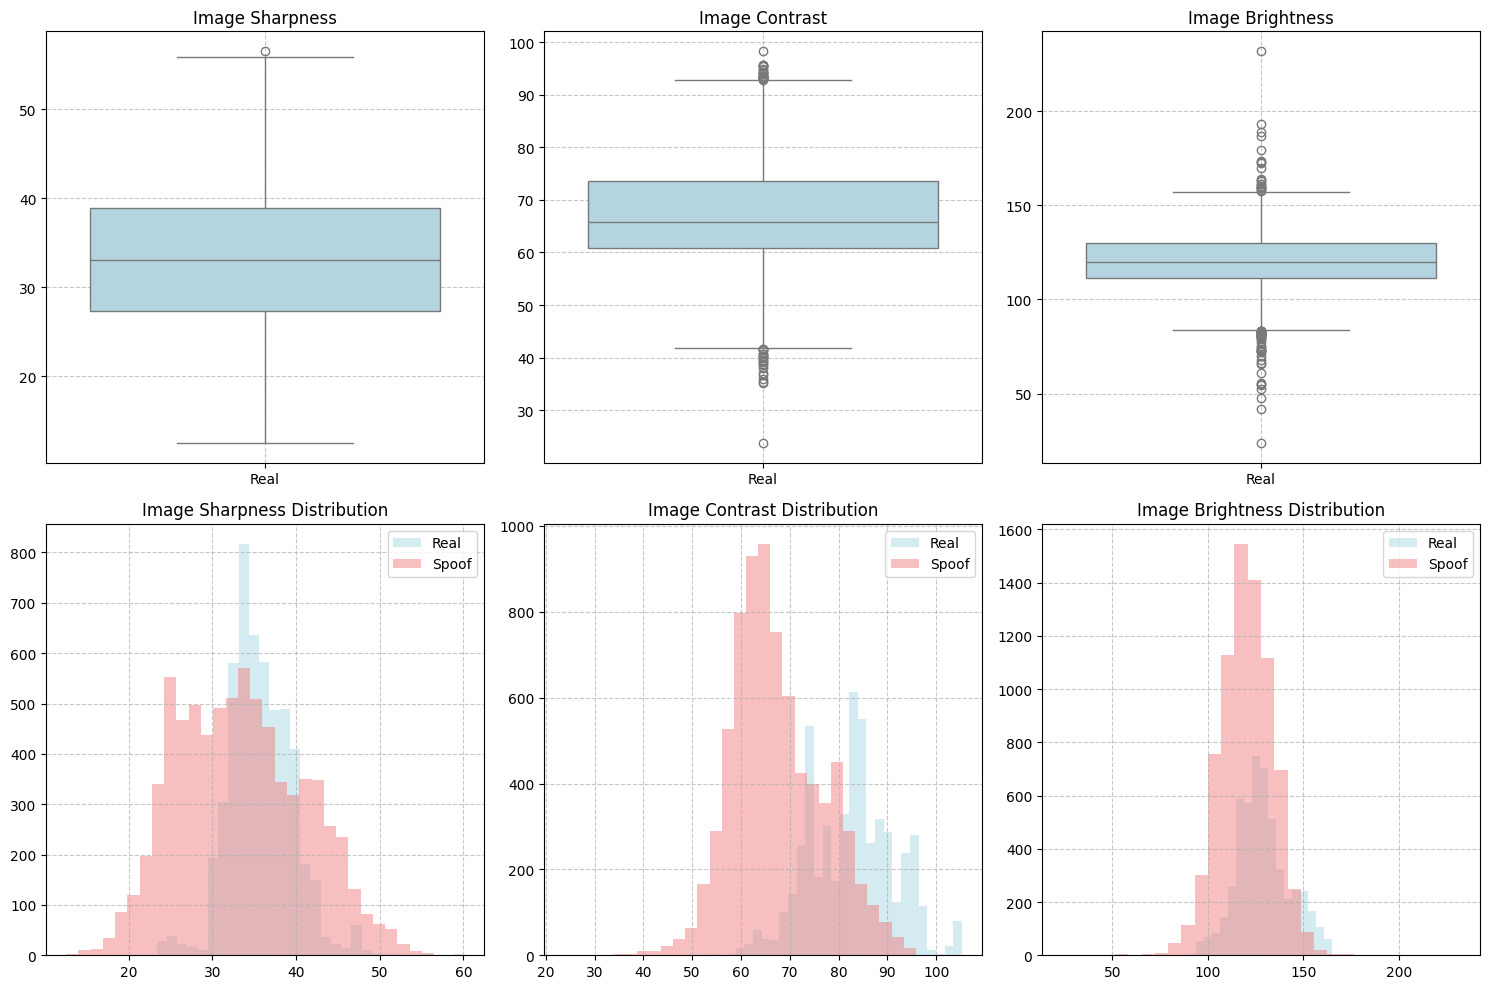


Image Quality Statistics:

Real Images:
         sharpness     contrast   brightness
count  5105.000000  5105.000000  5105.000000
mean     35.806030    82.675954   128.857222
std       3.909667     8.714655    13.727252
min      23.336542    51.741991    72.937031
25%      33.259022    75.747609   119.358512
50%      35.456688    82.870419   127.425921
75%      38.380856    88.367140   136.859564
max      60.087311   105.301516   198.167230

Spoof Images:
         sharpness     contrast   brightness
count  7509.000000  7509.000000  7509.000000
mean     33.388367    67.375596   120.182556
std       7.576843     9.301531    13.820516
min      12.519183    23.741884    23.687601
25%      27.394693    60.874010   111.252295
50%      33.043907    65.840193   119.975853
75%      38.897675    73.638300   129.758021
max      56.520294    98.318219   231.910684


In [43]:
# Image quality metrics
def compute_image_quality(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        # Convert to gray
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Compute gradients
        gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1)

        # Gradient magnitude
        grad_mag = np.sqrt(gx * gx + gy * gy)
        sharpness = np.mean(grad_mag)

        # Contrast
        contrast = gray.std()

        # Brightness
        brightness = np.mean(gray)

        return {"sharpness": sharpness, "contrast": contrast, "brightness": brightness}
    return None


# Analyze image quality metrics
def analyze_image_quality(directory):
    """Analyze quality metrics for all images"""
    files = []
    for root, dirs, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith((".jpg", ".png")):
                files.append(os.path.join(root, filename))

    if not files:
        return pd.DataFrame()

    quality_metrics = []
    for f in tqdm(files, desc=f"Analyzing quality in {os.path.basename(directory)}"):
        metrics = compute_image_quality(f)
        if metrics:
            quality_metrics.append(metrics)

    return pd.DataFrame(quality_metrics)


print("\nAnalyzing image quality metrics...")
client_quality = analyze_image_quality(client_path)
imposter_quality = analyze_image_quality(imposter_path)

# Plot quality metrics with improved visualization
if not client_quality.empty and not imposter_quality.empty:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    metrics = ["sharpness", "contrast", "brightness"]
    titles = ["Image Sharpness", "Image Contrast", "Image Brightness"]

    # Box plots
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        sns.boxplot(
            data=[client_quality[metric], imposter_quality[metric]],
            ax=axes[0, i],
            palette=["lightblue", "lightcoral"],
        )
        axes[0, i].set_xticklabels(["Real", "Spoof"])
        axes[0, i].set_title(title)
        axes[0, i].grid(True, linestyle="--", alpha=0.7)

    # Histograms
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        axes[1, i].hist(
            client_quality[metric], bins=30, alpha=0.5, label="Real", color="lightblue"
        )
        axes[1, i].hist(
            imposter_quality[metric],
            bins=30,
            alpha=0.5,
            label="Spoof",
            color="lightcoral",
        )
        axes[1, i].set_title(f"{title} Distribution")
        axes[1, i].grid(True, linestyle="--", alpha=0.7)
        axes[1, i].legend()

    plt.tight_layout()
    plt.show()

    # Statistical summary
    print("\nImage Quality Statistics:")
    print("\nReal Images:")
    print(client_quality.describe())
    print("\nSpoof Images:")
    print(imposter_quality.describe())

else:
    print("No valid images found for analysis")